In [3]:
import math
import numpy as np

filename = "EK95.txt"
EKMF95 = np.loadtxt(filename, skiprows=0)

print(EKMF95[20,:])

def QxEK95(gender,x,t,param =[]):
    return(EKMF95[x,gender+1])

print(QxEK95(0,20,2020))

def Qx(gender,x,t,param =[]):
    # This is our default mortality
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxNoReduction(gender,x,t,param =[]):
    # This is our default mortality
    t = 2015
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxMedieval(gender,x,t,param =[]):
    a=-9.13275
    b= 8.09432e-2
    c= -1.1018e-5
    value=math.exp(a+(b+c*x)*x)
    alpha = 7.26502413
    beta = 0.01342065
    return(max(0,min(1,alpha*value+beta)))

def ConstantBenefit(x,param=[]):
    return(1.)

def ZeroBenefit(x,param=[]):
    return(0.)

def ExpBenefit(x,param=[]):
    x0 = param[0]
    alpha = param[1]
    return((1+alpha)**(x-x0))

def DeferredBenefit(x,param=[]):
    x0 = param[0]
    if x>= x0: return(1)
    return(0)

[2.0000e+01 2.2539e-03 8.5330e-04]
0.0022539


**Mathematical Reserves**

\begin{eqnarray*}
{}_{t}V &=& PV_{Future Benefits} - PV_{Future Premium}
\end{eqnarray*}

**Recursion** 

\begin{eqnarray*}
{}_{t}V_{x} + \Pi_{x+t}  &=& C_{x+t} \, q_{x+t} \, v + p_{x+t} \, v \, {}_{t+1} V_{x} \\
\Pi^{s}_{x+t} & = & v\, {}_{t+1}V_{x} - {}_{t}V_{x} \\
\Pi^{r}_{x+t} & = & q_{x+t} v\, (C_{x+t} - {}_{t+1}V_{x})
\end{eqnarray*}

**How do we calculate a premium?**

By the equivalence principle. This is equivelent to the condition ${}_{0}V_x = 0$

In [6]:
import numpy as np
import matplotlib.pyplot as plt

class Capital:
    def __init__(self,Qx,i=0.02,omega=110,t0 = 2020):
        self.dIrate = i
        self.nOmega = omega
        self.psymB = ConstantBenefit
        self.psymM = ConstantBenefit
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        
    def CommFu(self,gender,x,symbol):
        # Allowable symbnols l, D, N, S, C, M, R
        if symbol == "l":
            l = 100000.
            px = 1.
            for i in range(x):
                t = self.nT0 + i
                qx = self.psymQx(gender,i,t) 
                px *= (1-qx)
            return(l * px)
        if symbol == "D":
            return(self.CommFu(gender,x,"l")*self.dV**x)
        if symbol == "C":
            return((self.CommFu(gender,x,"l")-self.CommFu(gender,x+1,"l"))*self.dV**(x+1))
        if symbol == "N":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"D")
            return(sum)
        if symbol == "S":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"N")
            return(sum)
        if symbol == "M":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"C")
            return(sum)
        if symbol == "R":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"M")
            return(sum)
        return("Error")
        
    def CalcPV(self,gender,x,s,param=[]):
        PV = self.psymM(s,param=param)
        n  = s-x
        for i in range(s-1,x-1,-1):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            px = 1. - qx
            PV = qx * self.dV * self.psymB(i,param=param) + px * self.dV * PV
        return(PV)
    
    def CalcCF(self,gender,x,s,periods = 50,param=[]):
        CF = np.zeros(periods)
        px = 1
        for i in range(x,s):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            n = i - x
            if n >= periods:
                break
            CF[n] = px * qx * self.psymB(i,param=param)
            px *= (1-qx)
            #print(i, px, qx)
        
        n = s - x
        if n < periods:
            CF[n] = px * self.psymM(s,param=param)
            
        return(CF)
    


class Annuity:
    def __init__(self,Qx,i=0.02,omega=110,t0 = 2020):
        self.dIrate = i
        self.nOmega = omega
        self.psymB = ConstantBenefit
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        
    def CommFu(self,gender,x,symbol):
        # Allowable symbnols l, D, N, S, C, M, R
        if symbol == "l":
            l = 100000.
            px = 1.
            for i in range(x):
                t = self.nT0 + i
                qx = self.psymQx(gender,i,t) 
                px *= (1-qx)
            return(l * px)
        if symbol == "D":
            return(self.CommFu(gender,x,"l")*self.dV**x)
        if symbol == "C":
            return((self.CommFu(gender,x,"l")-self.CommFu(gender,x+1,"l"))*self.dV**(x+1))
        if symbol == "N":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"D")
            return(sum)
        if symbol == "S":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"N")
            return(sum)
        if symbol == "M":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"C")
            return(sum)
        if symbol == "R":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"M")
            return(sum)
        return("Error")
        
    def CalcPV(self,gender,x,s,param=[]):
        PV = 0
        n  = s-x
        for i in range(s-1,x-1,-1):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            px = 1. - qx
            PV = self.psymB(i,param=param) + px * self.dV * PV
        return(PV)
    
    def CalcCF(self,gender,x,s,periods = 50,param=[]):
        CF = np.zeros(periods)
        px = 1
        for i in range(x,s):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            n = i - x
            if n >= periods:
                break
            CF[n] = px  * self.psymB(i,param=param)
            px *= (1-qx)
            #print(i, px, qx)
            
        return(CF)
    
class DK:
    def __init__(self,Qx,strType, i=0.02,omega=110,t0 = 2020):
        self.dIrate = i
        self.nOmega = omega
        self.psymB = ConstantBenefit
        self.psymM = ConstantBenefit
        self.psymP = ConstantBenefit
        self.dPrem = None
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        self.psymLeist = None
        self.psymPraem = None
        self.nSL = None
        self.nSP = None
        self.nGender = None
        self.strType = strType
        if self.strType == "A":
            self.strComment = "Annuity"
            self.psymLeist = Annuity(Qx,i=i,omega=omega,t0 = t0)
        else:
            self.strComment = "Capital"
            self.psymLeist = Capital(Qx,i=i,omega=omega,t0 = t0)
            
        self.psymPraem = Annuity(Qx,i=i,omega=omega,t0 = t0)
        print("Setting up Object for:", self.strComment)
        
        
    def CommFu(self,gender,x,symbol):
        # Allowable symbnols l, D, N, S, C, M, R
        if symbol == "l":
            l = 100000.
            px = 1.
            for i in range(x):
                t = self.nT0 + i
                qx = self.psymQx(gender,i,t) 
                px *= (1-qx)
            return(l * px)
        if symbol == "D":
            return(self.CommFu(gender,x,"l")*self.dV**x)
        if symbol == "C":
            return((self.CommFu(gender,x,"l")-self.CommFu(gender,x+1,"l"))*self.dV**(x+1))
        if symbol == "N":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"D")
            return(sum)
        if symbol == "S":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"N")
            return(sum)
        if symbol == "M":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"C")
            return(sum)
        if symbol == "R":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"M")
            return(sum)
        return("Error")
    
    def CalcPremium(self,gender,x,sL,sP,param=[]):
        self.nSL = sL
        self.nSP = sP
        self.nGender = gender
        self.psymLeist.psymB = self.psymB
        self.psymLeist.psymM = self.psymM
        self.psymPraem.psymB = self.psymP
        self.dPrem = self.psymLeist.CalcPV(self.nGender,x,self.nSL,param=param)/self.psymPraem.CalcPV(self.nGender,x,self.nSP,param=param)
        print(self.psymLeist.CalcPV(self.nGender,x,self.nSL,param=param),self.psymPraem.CalcPV(self.nGender,x,self.nSP,param=param))
        print("Premium =",self.dPrem)
    
    def CalcPV(self,x,param=[]):
        PVL = self.psymLeist.CalcPV(self.nGender,x,self.nSL,param=param)
        PVP = self.psymPraem.CalcPV(self.nGender,x,self.nSP,param=param) * self.dPrem
        PV = PVL - PVP
        return([PVL, PVP, PV])
    
    def CalcCF(self,x,periods = 50,param=[]):
        CFL = self.psymLeist.CalcCF(self.nGender,x,self.nSL,periods = periods, param=param)
        CFP = -self.dPrem * self.psymPraem.CalcCF(self.nGender,x,self.nSP,periods = periods, param=param)
        CF  = CFL + CFP
        return([CFL,CFP,CF])

Condsider Deferred Annuity with Premium Payment until retirement
Setting up Object for: Annuity
30.918461845107885 24.570444365340112
Premium = 1.2583598971747738
6.348017479767778 24.570444365340112
Premium = 0.25835989717477403


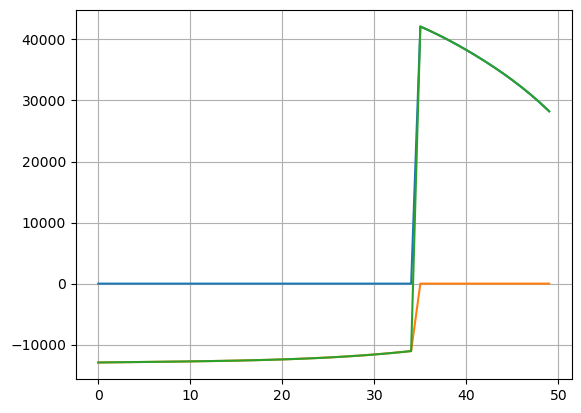

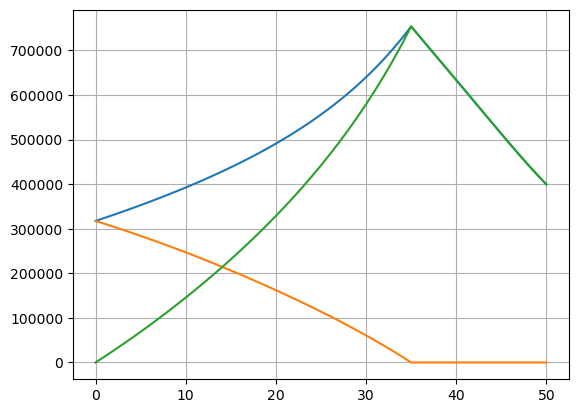

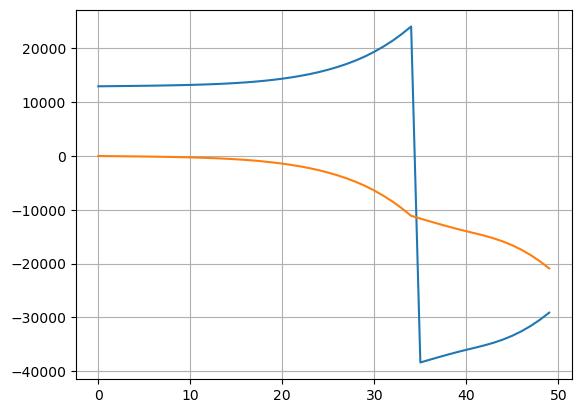

In [8]:
import matplotlib.pyplot as plt
print("Condsider Deferred Annuity with Premium Payment until retirement")
gender = 0
x= 30
s= 65
R = 50000 #pa
omega=120
MyPolicy = DK(QxEK95,"A")
#MyPolicy.psymB =DeferredBenefit
MyPolicy.CalcPremium(gender,x,omega,s,param=[s])
MyPolicy.psymB =DeferredBenefit
MyPolicy.CalcPremium(gender,x,omega,s,param=[s])
(CFL,CFP,CF) = MyPolicy.CalcCF(x,param=[s])
plt.figure(1)
plt.plot(range(len(CFL)),R*CFL,range(len(CFL)),R*CFP,range(len(CFL)),R*CF)
plt.grid(True)
PVL = []
PVP = []
PV =[]
for t in range(51):
    (PVLt, PVPt, PVt) = MyPolicy.CalcPV(x+t,param=[s])
    PVL.append(PVLt*R)
    PVP.append(PVPt*R) 
    PV.append(PVt*R)
plt.figure(2)
plt.plot(range(len(PVL)),PVL,range(len(PVL)),PVP,range(len(PV)),PV)
plt.grid(True)

SP = []
RP = []
v = 1/1.02
C = 0
for t in range(50):
    qx = MyPolicy.psymQx(gender,x+t,2020+t)
    spt = PV[t+1] * v - PV[t]
    rpt = qx * v * (C - PV[t+1])
    SP.append(spt)
    RP.append(rpt)
    
plt.figure(3)
plt.plot(range(len(SP)),SP,range(len(RP)),RP)
plt.grid(True)

**How do we interprete RP ?**

This is actually the expect cost for the cover.

***Reserve Strengthening Context and Task***
What we want to analyse here is to see the impact of changed mortality tabels and also interest rates in a very simple context. We will calculate the ipact on reserves.

To this end we assume a given annuity vector $r(x)$ which denotes the sum of all annuities in payment today for age $x$.

In [12]:
def ValueProtfolio(Qx, interst, Portfolio, t0):
    # Returns Mathematical Reserve of the portfolio 
    # Sturcture of portfolio (age gender annuity)
    Vx = 0 
    Rp = 0
    aex = Annuity(Qx,i=interst,t0 = t0)
    for i in Portfolio:
        Vx +=aex.CalcPV(i[1],i[0],110)*i[2]
        #print(i[1],i[0])
        Rp +=aex.psymQx(i[1],i[0],t0)*(0-aex.CalcPV(i[1]+1,i[0],110))*i[2]/(1+interst) # qx * v *(c - Vx+1)
        
    return(Vx, Rp)
    
Portfolio =[]
Portfolio.append([65,0,1.e7])
Portfolio.append([70,0,5.e6])
Portfolio.append([80,0,2.5e6])
Portfolio.append([90,0,5.e5])

In [14]:
QxTables =  dict()
QxTables["Medieval"] = QxMedieval
QxTables["EK95"] = QxEK95
QxTables["Current No Trend"] = QxNoReduction
QxTables["Current Trend"] = Qx
QxTables["Current Trend 2030"] = Qx
QxTables["Current Trend 2040"] = Qx

MyT = [2020,2020,2020,2020,2030,2040]
iRates = [0., 0.02, 0.04]

strOut = "%-20s | %10.6f %10.6f %10.6f %10s\n"%("Interest Rate:", iRates[0], iRates[1], iRates[2],"Risk Prem")
strOut += "----- ----- ----- ----- ----- ----- ----- ----- ----- -----\n"
j = 0
for t in QxTables.keys():
    ta = QxTables[t]
    strOut += "%-20s | "%t
    for i in iRates:
        Vx,RP = ValueProtfolio(ta, i, Portfolio, MyT[j])
        strOut += "%10.0f "%(Vx/1000000)
    strOut += "%10.2f "% (RP/100000) #note at 4%
    strOut +="\n"
    j+=1

print(strOut)

Interest Rate:       |   0.000000   0.020000   0.040000  Risk Prem
----- ----- ----- ----- ----- ----- ----- ----- ----- -----
Medieval             |         72         69         65    -129.58 
EK95                 |        284        236        201     -51.58 
Current No Trend     |        298        246        209     -44.48 
Current Trend        |        341        274        227     -44.36 
Current Trend 2030   |        366        290        238     -39.45 
Current Trend 2040   |        393        307        249     -34.97 



**Release of Reserve for a policy**

Assume $n$ Policies of age $x$ and annuity $R_k$. Denote by $I_k$ the random variable indicating that person $k$ dies during a year. Then we have $\mathbb{E}[I_k] =q_x^{BE}$.

For Reserving we use another mortality $q_x$ and we expect the released reserve to be $\Pi^{R}_k$. So for the portfolio we would expect that the following amount is released.

\begin{eqnarray*}
RP  & = & -\sum_{k=1}^n R_k \, v \, q_x \, \ddot{a}_x
\end{eqnarray*}

In reality we release

\begin{eqnarray*}
r(\omega)  & = & -\sum_{k=1}^n R_k \, v \, I_k(\omega) \, \ddot{a}_x
\end{eqnarray*}

In consequence the profit and loss is $R -r(\omega)$

\begin{eqnarray*}
\mathbb{E}[r(\omega)]  & = & -\sum_{k=1}^n R_k \, v \, q_x^{BE} \, \ddot{a}_x
\end{eqnarray*}

Therfore

\begin{eqnarray*}
R - \mathbb{E}[r(\omega)]    & = & \sum_{k=1}^n R_k \, v \, (q_x^{BE} - q_x) \, \ddot{a}_x
\end{eqnarray*}

The above concept is how you measure profitabilty of a life insurer. The first step is to calulate the total risk premium of the inforce and compare it with the effective risk premium as per the accounts

For a general insurance one needs to adjust for the capital payment

\begin{eqnarray*}
RP  & = & \sum_{k=1}^n q_{x_k} \, v \, (C_k - V_{k+1}) \\
r(\omega)  & = & \sum_{k=1}^n I_k \, v \, (C_k - V_{k+1})
\end{eqnarray*}



**How does reserve Strengtheing work in reality**

Example

we have written

- 1990 written 10M Annuities for 65y people (i=3.5%) 1.20 of Current No Trend
- 2000 written 20M Annuities for 65y people (i=2.5%) 1.15 of Current No Trend
- 2010 written 30M Annuities for 65y people (i=1.5%) 1.10 of Current No Trend

Today we want to evaliuate this portfolio with Current and i=1%

Steps Move forward the portfolio to today by looking at the effective inforce

- 1990 written 10M --> 1M Annuities for 95y people (i=3.5%) 1.20 of Current No Trend
- 2000 written 20M --> 10M Annuities for 85y people (i=2.5%) 1.15 of Current No Trend
- 2010 written 30M --> 22M Annuities for 75y people (i=1.5%) 1.10 of Current No Trend

In [11]:


def QxNoReductionLevel(gender,x,t,param =[]):
    # This is our default mortality
    t = 2015
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    level = param[0]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t)*level)

def Qx120(gender,x,t,param =[]):
    # This is our default mortality
    t = 2015
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    level = 1.2
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t)*level)
def Qx115(gender,x,t,param =[]):
    # This is our default mortality
    t = 2015
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    level = 1.15
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t)*level)

def Qx110(gender,x,t,param =[]):
    # This is our default mortality
    t = 2015
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    level = 1.1
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t)*level)

PortFolio = []
PortFolio.append([1.e6,0,95,Qx120,0.035])
PortFolio.append([10.e6,0,85,Qx115,0.025])
PortFolio.append([22.e6,0,75,Qx110,0.015])

In [16]:
def ValueProtfolio2(Qx, interst, Portfolio, t0):
    # Returns Mathematical Reserve of the portfolio 
    # Sturcture of portfolio (age gender annuity)
    aex = Annuity(Qx,i=interst,t0 = t0)
    VPast =0
    VNew=0
    for i in Portfolio:
        r = i[0]
        gen  = i[0]
        age  = i[2]
        table = i[3]
        ipast = i[4]
        aexPast = Annuity(table,ipast,t0 = t0)
        VPast +=aexPast.CalcPV(gen,age,110)*r
        VNew +=aex.CalcPV(gen,age,110)*r
    return([VPast,VNew])

In [17]:
[a,b] = ValueProtfolio2(Qx, 0.01, PortFolio, 2020)

In [19]:
print(a*1e-6,b*1e-6,(b-a)*1e-6)

347.1766835752363 423.59567162055697 76.41898804532069


**Homework**

-Refine the approach to also split the effect into Mortatlity vs interest rate

-What does this mean for the effective risk premium vs calcuated one